## Uplift modeling using Python and Pyrsm

Please note that this example data is stacked, that is, treatment and control data are in the same DataFrame with a binary `treat` variable that indicates whether the observations are from the treatment or the control condition. This will be important when we work on second part of the Creative Gaming case because we will need to organize the data in a specific stack there.

The data in this example comes from a prediction contest run by Kaggle. The variables are masked and do not have any intrinsic meaning. `y` captures if a customer purchased or not ("yes" or "no"); `treat` denotes if the customer was shown an ad (i.e., customer was in the treatment or in the control group); and the `X1` to `X20` variables are features we can use for prediction although we do not know what they represent.

In [1]:
import pandas as pd
import pyrsm as rsm

# checking pyrsm version
# pip install --user pyrsm --upgrade
rsm.__version__  # should be 0.9.18 or higher

'0.9.18'

In [2]:
# setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm


In [3]:
## loading the data - this dataset must NOT be changed
# kaggle_uplift = pd.read_pickle("data/kaggle_kellogg.pkl")
# kaggle_uplift[["y", "treat"]] = kaggle_uplift[["y", "treat"]].astype(int)

kaggle_uplift = pd.read_parquet("data/kaggle_uplift.parquet")
kaggle_uplift.head()

,y,treat,X1,X2,X3,X4,X5,X6,X7,X8,...,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,no,0,-0.839122,-1.184473,-0.618753,0.919529,0.646708,-0.863779,0.681583,0.941491,...,1.755714,-1.461228,0.221521,-1.949649,1.950216,0.363726,-1.896798,-0.199957,0.169923,-0.803328
1,no,0,0.067667,0.196872,-1.905389,-1.139579,0.778807,0.583258,0.117321,1.293713,...,-0.191139,-0.279909,-0.673368,0.177512,-1.266496,-1.112269,1.068229,-1.260233,-0.155124,-0.042090
2,no,0,-2.910450,1.662337,0.632232,-0.833931,0.602070,2.250293,-0.534271,-0.369958,...,-0.433851,-0.328418,1.029167,-0.683077,1.980124,0.183217,1.374955,0.354499,0.772177,-0.877702
3,no,1,2.173894,-0.470122,-0.673128,-0.711156,-0.125007,0.258518,-1.762345,1.175512,...,1.768923,-0.467989,0.358986,1.167883,-0.160814,-1.595267,-0.398611,-0.284847,0.615662,-0.740649
4,no,0,0.201251,0.582766,0.112437,0.541175,-0.096795,-0.303140,-0.240222,0.500051,...,0.370656,-0.966091,-0.071090,-0.755591,-1.676977,0.125311,2.291795,1.414520,2.042719,-0.387430


## Create a train/test split in the uplift data

We will create a training variable that keeps the proportion of buyers non-buyers (almost) the same in both the training and test samples. This needs to apply to training and test in the treatment (treat == 1) and control (treat == 0) sample. We can use pyrsm to access sklearn's StratifiedShuffleSplit functionality for this. Starting with a 50/50 training variable, for illustration purposes.

In [4]:
kaggle_uplift["training"] = rsm.model.make_train(
    data=kaggle_uplift, test_size=0.5, strat_var=["y", "treat"]
)

We can check that randomization kept the proportions pretty even compared to the overall proportsions

> Note: We need the yes/no ratio to be as similar as possible in training and test by treatment level. We expect that the ratio of yes/no may differ for the treatment vs the control level

In [5]:
pd.crosstab(kaggle_uplift.y, [kaggle_uplift.treat, kaggle_uplift.training]).round(2)

treat       0         1     
training  0.0  1.0  0.0  1.0
y                           
yes       120  119  136  135
no        130  131  114  115

In [6]:
pd.crosstab(
    kaggle_uplift.y, [kaggle_uplift.treat, kaggle_uplift.training], normalize="columns"
).round(2)

treat        0           1      
training   0.0   1.0   0.0   1.0
y                               
yes       0.48  0.48  0.54  0.54
no        0.52  0.52  0.46  0.46

Lets create a new training variable with a better split (70/30) and, again, check that randomization very even compared to the overall proportions

> Note: We need the yes/no ratio to be as similar as possible in training and test by treatment level. We expect that the ratio of yes/no may differ for the treatment vs the control level. If the test has the desired effect, these numbers **should** be different

In [7]:
kaggle_uplift["training"] = rsm.model.make_train(
    data=kaggle_uplift, test_size=0.3, strat_var=["y", "treat"]
)

In [8]:
kaggle_uplift.training.value_counts(normalize=True)

training
1.0    0.7
0.0    0.3
Name: proportion, dtype: float64

In [9]:
pd.crosstab(
    kaggle_uplift.y, [kaggle_uplift.treat, kaggle_uplift.training], normalize="columns"
).round(2)

treat        0           1      
training   0.0   1.0   0.0   1.0
y                               
yes       0.48  0.48  0.54  0.54
no        0.52  0.52  0.46  0.46

## Estimate seperate logistic regression models for the treatment and control sample

In [10]:
pd.crosstab(kaggle_uplift.treat, kaggle_uplift.training)

training,0.0,1.0
treat,,
0,150,350
1,150,350


In [11]:
lr_treatment = rsm.model.logistic(
    data={"kaggle_uplift": kaggle_uplift.query("training == 1 & treat == 1")},
    rvar="y",
    lev="yes",
    evar=kaggle_uplift.loc[:, "X1":"X20"].columns.tolist(),
)
lr_treatment.summary()

Logistic regression (GLM)
Data                 : kaggle_uplift
Response variable    : y
Level                : yes
Explanatory variables: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20
Null hyp.: There is no effect of x on y
Alt. hyp.: There is an effect of x on y

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  1.210   21.0%         0.19      0.137    1.388   0.165     
X1         0.560  -44.0%        -0.58      0.154   -3.779  < .001  ***
X2         1.940   94.0%         0.66      0.155    4.277  < .001  ***
X3         0.336  -66.4%        -1.09      0.167   -6.541  < .001  ***
X4         2.723  172.3%         1.00      0.163    6.145  < .001  ***
X5         0.611  -38.9%        -0.49      0.155   -3.186   0.001   **
X6         1.210   21.0%         0.19      0.147    1.295   0.195     
X7         0.652  -34.8%        -0.43      0.157   -2.723   0.006   **
X8         1.438   43.8%         0.36      0.146    

In [12]:
lr_control = rsm.model.logistic(
    data={"kaggle_uplift": kaggle_uplift.query("training == 1 & treat == 0")},
    rvar="y",
    lev="yes",
    evar=kaggle_uplift.loc[:, "X1":"X20"].columns.tolist(),
)
lr_control.summary()

Logistic regression (GLM)
Data                 : kaggle_uplift
Response variable    : y
Level                : yes
Explanatory variables: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20
Null hyp.: There is no effect of x on y
Alt. hyp.: There is an effect of x on y

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.995   -0.5%        -0.01      0.131   -0.040   0.968     
X1         1.963   96.3%         0.67      0.140    4.803  < .001  ***
X2         0.591  -40.9%        -0.53      0.147   -3.579  < .001  ***
X3         1.540   54.0%         0.43      0.140    3.083   0.002   **
X4         0.607  -39.3%        -0.50      0.132   -3.773  < .001  ***
X5         0.841  -15.9%        -0.17      0.124   -1.393   0.164     
X6         1.268   26.8%         0.24      0.131    1.819   0.069    .
X7         0.823  -17.7%        -0.19      0.129   -1.514    0.13     
X8         1.361   36.1%         0.31      0.127    

## Create predictions and the uplift score for each customer in the test data 

For each customer in the test data (regardless of whether they were in the treatment group or the control group), we get `Prob(purchase | treated)` and `Prob(purchase | not treated)` from the above models and then take their difference (i.e., the uplift score):

In [13]:
kaggle_uplift["pred_treatment"] = lr_treatment.predict(kaggle_uplift)["prediction"]
kaggle_uplift["pred_control"] = lr_control.predict(kaggle_uplift)["prediction"]

Once we have the predictions, we can calculate the `uplift score`:


In [14]:
kaggle_uplift["uplift_score"] = (
    kaggle_uplift.pred_treatment - kaggle_uplift.pred_control
)

## Let's look at the data

Sort the data on uplift score from highest to lowest and select a few key columns.

In [15]:
(
    kaggle_uplift[
        ["y", "treat", "training", "pred_treatment", "pred_control", "uplift_score"]
    ]
    .query("training == 0")
    .sort_values("uplift_score", ascending=False)
)

,y,treat,training,pred_treatment,pred_control,uplift_score
269,yes,1,0.0,0.987781,0.103113,0.884668
728,no,0,0.0,0.939614,0.074139,0.865475
516,yes,1,0.0,0.917204,0.061802,0.855402
218,yes,1,0.0,0.967726,0.112997,0.854730
636,no,0,0.0,0.925352,0.085639,0.839713
...,...,...,...,...,...,...
521,yes,0,0.0,0.063253,0.900114,-0.836862
591,no,1,0.0,0.055933,0.895342,-0.839409
417,no,1,0.0,0.050069,0.921100,-0.871031
566,yes,0,0.0,0.048836,0.930454,-0.881618


## Evaluate the performance of the uplift model

To calculate performance measures we can use the `uplift_tab` function from the pyrsm packages

In [16]:
tab = rsm.uplift_tab(
    kaggle_uplift.query("training == 0"), "y", "yes", "uplift_score", "treat", 1
)
tab

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,uplift_score,1,0.1,14,15,1,10,12.500000,8.333333,0.833333
1,uplift_score,2,0.2,26,30,3,21,21.714286,14.476190,0.618182
2,uplift_score,3,0.3,37,45,10,40,25.750000,17.166667,0.364912
3,uplift_score,4,0.4,47,60,20,60,27.000000,18.000000,0.166667
4,uplift_score,5,0.5,55,75,25,77,30.649351,20.432900,0.239216
5,uplift_score,6,0.6,64,90,28,85,34.352941,22.901961,0.225000
6,uplift_score,7,0.7,70,105,37,104,32.644231,21.762821,-0.073684
7,uplift_score,8,0.8,77,120,45,117,30.846154,20.564103,-0.148718
8,uplift_score,9,0.9,81,135,60,138,22.304348,14.869565,-0.447619
9,uplift_score,10,1.0,81,150,72,150,9.000000,6.000000,-1.000000


You should recognize this output from the slides we discussed in class. We can now plot Incremental Uplift (i.e., Incremental Responses / Total Number Treated):

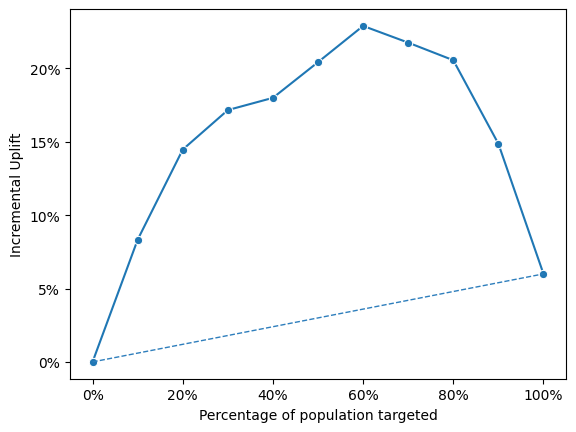

In [17]:
fig = rsm.inc_uplift_plot(
    kaggle_uplift.query("training == 0"), "y", "yes", "uplift_score", "treat", 1
)

Finally, we can plot Uplift (i.e., the difference between the Treatment and Control conversion percentages):

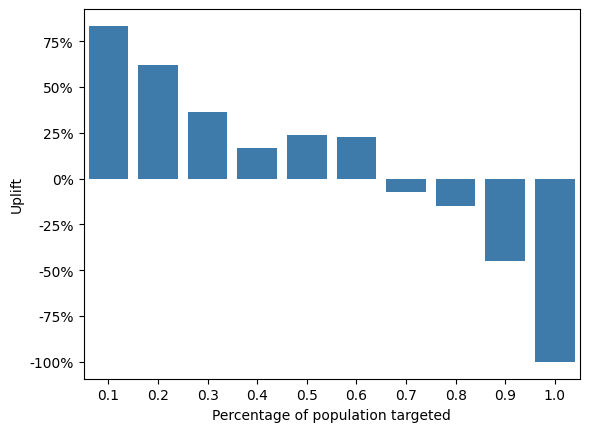

In [18]:
fig = rsm.uplift_plot(
    kaggle_uplift.query("training == 0"), "y", "yes", "uplift_score", "treat", 1
)

## Compare performance of the uplift model to a propensity model

We can also compare the performance of our uplift model to a propensity model. We can obtain the uplift table for the propensity model by adding `pred_treatment` 


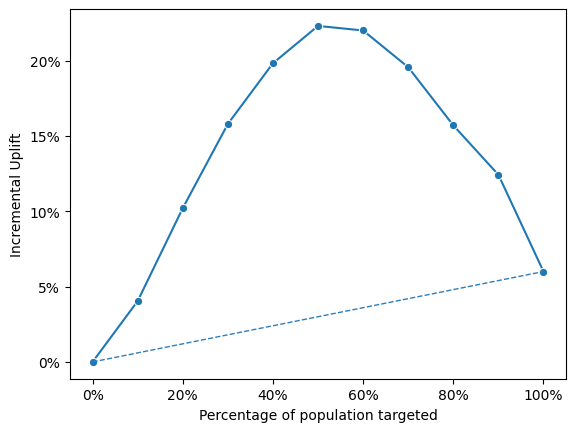

In [19]:
fig = rsm.inc_uplift_plot(
    kaggle_uplift.query("training == 0"), "y", "yes", "pred_treatment", "treat", 1
)

It is helpful to compare multiple models in the same graph.

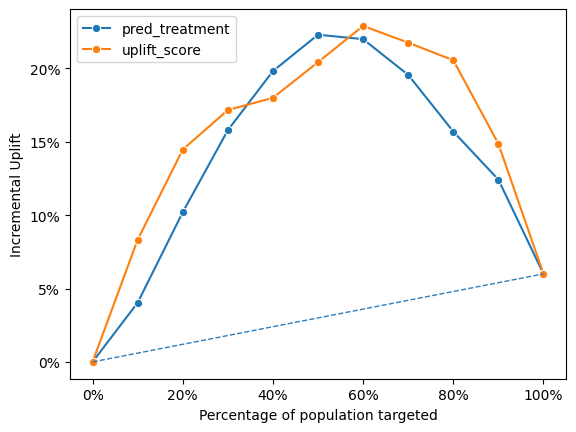

In [20]:
fig = rsm.inc_uplift_plot(
    kaggle_uplift.query("training == 0"),
    "y",
    "yes",
    ["pred_treatment", "uplift_score"],
    "treat",
    1,
)

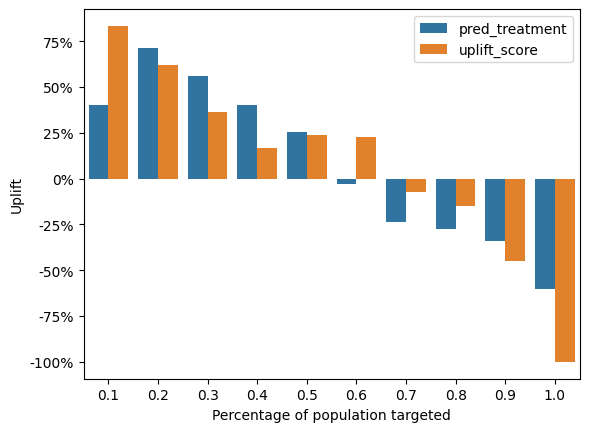

In [21]:
fig = rsm.uplift_plot(
    kaggle_uplift.query("training == 0"),
    "y",
    "yes",
    ["pred_treatment", "uplift_score"],
    "treat",
    1,
)

Notice that the uplift model places customers with high incrementality in earlier deciles. The incrementality is lower for the propensity model because it targets Persuadables and Sure Things whereas the uplift model targets only the former.

That said, the propensity model still performs well here; this is because the customers who have the best propensity also tend to have the best uplift in this data:

In [22]:
cm = rsm.correlation(
    {"kaggle_uplift": kaggle_uplift.loc[kaggle_uplift.training == 0, "pred_treatment":"uplift_score"]}
)
cm.summary()

Correlation
Data     : kaggle_uplift
Method   : pearson
Cutoff   : 0
Variables: pred_treatment, pred_control, uplift_score
Null hyp.: variables x and y are not correlated
Alt. hyp.: variables x and y are correlated

Correlation matrix:
             pred_treatment pred_control
pred_control          -0.38             
uplift_score           0.87        -0.78

p.values:
             pred_treatment pred_control
pred_control            0.0             
uplift_score            0.0          0.0


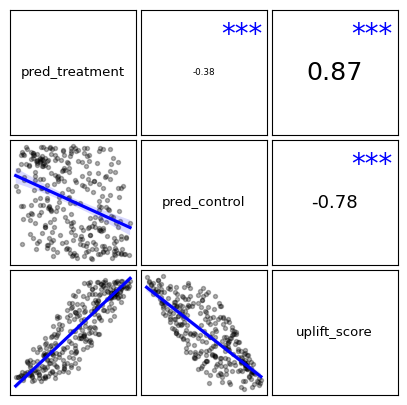

In [23]:
cm.plot()

In [24]:
kaggle_uplift.loc[kaggle_uplift.training == 0, "pred_treatment":"uplift_score"].corr()

,pred_treatment,pred_control,uplift_score
pred_treatment,1.000000,-0.376147,0.871033
pred_control,-0.376147,1.000000,-0.782786
uplift_score,0.871033,-0.782786,1.000000
